<a href="https://colab.research.google.com/github/aubaz/U-Exeter_RLforInventory/blob/main/2_MPNV_as_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Multi-Period Newsvendor Problem (MPNV) as an MDP

This notebook contains code for an MDP implementation of the multi-period newsvendor (MPNV) problem. 

---
> **Note:** This file is read-only. To work with it, you first need to save a copy to your Google Drive:
> 
> 1. Go to the File menu. (The File menu inside the notebook, right below the filename—not the File menu in your browser, at the top of your screen.)
> 2. Choose Save a copy in Drive. (Log in to your Google account, if necessary.) Feel free to move it to a different folder in your Drive, if you want.
> 3. Colab should open up a new browser tab with your copy of the notebook. 
> 4. Close the original read-only notebook in your browser.
---

---
> This notebook is part of the *Summer Bootcamp at Kellogg: RL in Operations* workshop at Northwestern University, August 2022. The notebooks are for Day 4, taught by Prof. Larry Snyder, Lehigh University. The full repo is at https://github.com/LarrySnyder/RLforInventory.
---

In the **multi-period newsvendor (MPNV)** problem, we must decide, in each time period, how much to order in advance of observing a random demand. Items that we order are received immediately (there is no lead time). Unmet demands are *backordered* (those customers are willing to wait until the next time period, with a penalty), and leftover items in inventory may be carried over to the next period (again, with a penalty).

The *inventory level* is the number of on-hand items minus the number of backorders:

$$IL = OH - BO.$$

Note that $IL$ can be positive, negative, or zero. The number of on-hand items and the number of backorders can never both be positive at the same time. Therefore, the number of on-hand items is $OH = IL^+$ and the number of backorders is $BO = (-IL)^+$, where $z^+ \equiv \max\{0, z\}$. 

Suppose we begin the time period with an inventory level (IL) of $x$ and order $Q$ units. We call $y \equiv x + Q$ the *order-up-to level*. If $y$ is greater than the demand $d$ in a given period (that is, we have more items than we need), we incur a *holding cost* of $h$ per item. On the other hand, if $y$ is less than the demand (we have fewer items than we need), we incur a *stockout cost* of $p$ per item. That is, the cost incurred in the time period is

$$h(y-d)^+ + p(d-y)^+ = h(x+Q-d)^+ + p(d-(x+Q))^+.$$

Of course, the demand is stochastic, and we must choose $Q$ (or, equivalently, $y$) before we observe it. 

We'll assume an **infinite horizon** (though finite-horizon versions of the problem exist, too; see Snyder and Shen, 2nd edition, 2019). Two common objective functions are used, one in which we minimize the expected cost per period and one in which we minimize the total discounted cost over the time horizon. 

We'll use the discounted version, meaning we are trying to minimize

$$\sum_{t=1}^\infty \gamma^{t-1}g_t(Q_t),$$

where $g_t(Q_t)$ is the expected cost in period $t$ if we use order quantity $Q_t$.



This problem can be formulated as a **Markov decision process (MDP)**. In this MDP, the state represents the IL at the beginning of the time period, and the action represents the order quantity. 

Now we'll start using more standard MDP notation:

* State = $s$ = inventory level (instead of $x$)
* Action = $a$ = order quantity (instead of $Q$)

Let $v_\pi(s)$ denote the **value function**: the expected return when starting in state $s$ (that is, starting a period with an IL of $s$) and folowing the **policy** $\pi$ thereafter. As usual, the policy $\pi$ is a mapping from states to actions. We'll assume it is a *deterministic policy* such that $\pi(s)$ is the action the policy specifies in state $s$.

The **Bellman equation** for the value function $v_\pi$ is:

$$v_\pi(s) = {\mathbb E}_D\left[ -\left(h(s + a -d)^+ + p(d - (s+a))^+\right) + \gamma v_\pi(s+a-D)\right],$$

where ${\mathbb E}_D$ denotes expectation over the random demand. For the optimal policy, the **Bellman optimality equation** is:

$$v_*(s) = \max_{a\ge 0} {\mathbb E}_D\left[ -\left(h(s+a-d)^+ + p(d-(s+a))^+\right) + \gamma v_*(s+a-D)\right].$$

The maximization is taken over all order quantities $a$, and since we cannot place an order of negative size, we require $a\ge 0$.



If we solve this MDP, we will find that the optimal policy follows a very particular structure. In particular, the optimal actions are given by:

$$\pi_*(s) = \begin{cases} S - s, & s < S \\ 0 & s \ge S \end{cases}$$

for some number $S$. Converting back to our inventory-theoretic notation, the optimal order quantity is given by

$$Q = \begin{cases} S - x, & x < S \\ 0 & x \ge S, \end{cases}$$

where $x$ is the starting inventory level. This type of ordering policy is called a **base-stock policy,** and the quantity $S$ is called the **base-stock level.**

---
> **Note:** The term *policy* is used somewhat differently in inventory theory than in MDP/RL theory. In inventory theory, a policy is a simple ordering rule, whereas in MDP/RL, it is a much more general mapping of states to actions. In other words, an inventory policy is a special case of an MDP/RL policy in which the optimal actions follow some simple or convenient structure.
>
> Also: Note that $S$, above, stands for the base-stock level, not for a "state" (as it often does in RL).
---

Once we know that a base-stock policy is optimal, the optimal base-stock level has a simple form: $S^*$ is the smallest $S$ such that

$$F(S) \ge \frac{p}{h+p}.$$

---
> **Note:** You might have been expecting the optimal base-stock level to depend on the discount factor, $\gamma$. It turns out that $S^*$ only depends on $\gamma$ if we also include a purchase cost $c$ per unit ordered from the supplier. Here, we assume $c=0$, so $S^*$ is independent of $\gamma$.
---

The fraction on the right-hand side is known as the *newsvendor fractile* or the *critical fractile*. The expected cost function and the optimal solution are mathematically identical to those for the (single-period) **newsvendor problem,** even though that problem assumes that unmet demands are lost (rather than backordered) and that extra inventory units are scrapped (rather than held).

(The results are similar if the demand has a continuous rather than discrete distribution, but we will only consider discrete distributions here.)

In this section, we will formulate and solve this problem as an MDP. This is possible since the dynamics of the system are fully known. We'll confirm, by solving the MDP numerically, that the optimal actions follow a base-stock policy. In the next section, we'll pretend that we don't know the dynamics and instead attack the problem using RL.

## Preliminary Python Stuff


In [ ]:
# Import the packages we will need.
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm
from tabulate import tabulate

In the code below, we'll use the `stockpyl` Python package (https://pypi.org/project/stockpyl/) for inventory optimization stuff. We have to install the `stockpyl` package ourselves. (It doesn't come pre-installed on Colab like `numpy`, etc. do.) You should only need to do this once per notebook.

If you get a message like

```
WARNING: The following packages were previously imported in this runtime:
  [sphinxcontrib]
You must restart the runtime in order to use newly installed versions.
```

you can ignore it.


In [ ]:
!pip install stockpyl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.3/146.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.1/525.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 706.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━

## MDP Class

The code below defines a Python class that implements algorithms for generic Markov decision processes (MDPs). The algorithm implementations are based on the discussions in Sutton and Barto (2nd edition, 2018).

The main input to the MDP is the `dynamics` dictionary, which represents the function $p(s',r|s,a)$. In particular, `dynamics[s,a][s_prime,r]` is the probability that state `s_prime` occurs next and earns reward `r` given that we are in state `s` and take action `a`. 

Note that `dynamics` is a dict of dicts: Its keys are (state, action) pairs, and its values are dicts whose keys are (next state, reward) pairs and whose values are probabilities.

---
> **Note:** In the code below, the portions that you need to complete are marked with
> 
> ```python
> # #################
> # TODO:
> ```
> 
> In place of the missing code is a line that says 
> 
> ```python
> 	raise NotImplementedError
> ```
> 
> This is a way of telling Python to raise an exception (error) because there's something missing here. You should **delete (or comment out) this line** after you write your code.

---

In [ ]:
class MDP(object):
    """Generic class for an MDP.

    ``dynamics`` is a dict whose keys are (state, action) pairs and whose values are dicts
    whose keys are (next_state, reward) pairs and whose values are probabilities.
    That is, dynamics[(s, a)][(s_prime, r)] is the probability that state s_prime and reward r
    results from taking action a in state s.
    Only (next_state, reward) pairs that have nonzero probability need to be included.
    """
    def __init__(self, dynamics, initial_state, terminal_states, gamma=0.9):
        # Parameters.
        self.dynamics = dynamics
        self.initial_state = initial_state
        self.terminal_states = terminal_states
        self.gamma = gamma

        # Build list of states.
        self.state_list = list({s for s, _ in self.dynamics.keys()})
        # Add terminal states. (These won't be in dynamics.)
        for s in terminal_states:
            if s not in self.state_list:
                self.state_list.append(s)
 
         # Build dict of allowable actions.
        self.allowable_actions = {}
        for s in self.state_list:
            self.allowable_actions[s] = list({a for state, a in self.dynamics if state == s})

    @property
    def nonterminal_state_list(self):
        return list(set(self.state_list).difference(self.terminal_states))

    def get_next_state_and_reward(self, state, action):
        """Return a next state and reward for a given (state, action) pair, 
        drawn from the pair's dynamics.
        """
        # Build lists of outcomes and probabilities.
        outcomes = list(self.dynamics[state, action].keys())
        probabilities = list(self.dynamics[state, action].values())

        # Draw next state and reward from the distribution.
        i = np.random.choice(range(len(outcomes)), p=probabilities)
        return outcomes[i]

    def get_action_from_policy(self, state, policy):
        """For a given state, return an action sampled from the specified policy."""
        actions = list(policy[state].keys())
        probabilities = list(policy[state].values())

        i = np.random.choice(range(len(actions)), p=probabilities)

        return actions[i]

    def get_action_equiprobable(self, state):
        """For a given state, return an action sampled from an equiprobable policy."""
        i = np.random.randint(len(self.allowable_actions[state]))
        return self.allowable_actions[state][i]

    def iterative_policy_evaluation(self, policy, initial_values=None, 
                                 theta=0.001, max_iter=None):
        """Iterative policy evaluation algorithm for estimating V \approx v_pi.
        (Section 4.1, p. 75.)
        
        ``policy`` is a dict whose keys are states and whose values are dicts in 
        which keys are actions and values are probabilities. That is, policy[s][a] 
        is the probability of action a in state s.
        
        NOTE: If there is a state from which no terminal state is reachable -- 
        e.g., the policy goes left from (2, 2) and right from (1, 2) -- this 
        algorithm will not converge. The method does not check for this.
        """

        # Initialize value function estimate.
        V = {}
        for s in self.state_list:
            if (s not in self.terminal_states) and (initial_values is not None) \
        and (s in initial_values):
                V[s] = initial_values[s]
            else:
                V[s] = 0
        k = 0

        # Loop.
        while True:
            Delta = 0
            k += 1
            # Make static copy of V. (Although Sutton and Barto's pseudocode doesn't 
              # indicate this, their results suggest that they are using the same V on 
              # the RHS throughout the entire iteration, even though the V[s] values 
              # will change throughout the iteration.)
            V_copy = copy.deepcopy(V)
            # Loop through nonterminal states.
            for s in self.nonterminal_state_list:
                v = V[s]
                # Update V[s].
                V[s] = 0
                for a in self.allowable_actions[s]:
                    if a in policy[s]:
                        pi = policy[s][a]
                        for s_prime, r in self.dynamics[(s, a)].keys():
                            p = self.dynamics[(s, a)][(s_prime, r)]
                            V[s] += pi * p * (r + self.gamma * V_copy[s_prime])

                # Update Delta.
                Delta = max(Delta, abs(v - V[s]))

            # Terminate?
            if Delta < theta or (max_iter is not None and k >= max_iter):
                break

        return V

    def greedy_policy(self, value_function, deterministic=False):
        """Return greedy policy from given value function as described in 
        Section 4.2, p.79.
        
        If a given state has multiple maximizing actions, then:
        * If `deterministic` is True, the action that comes earliest in the state list is chosen.
        * If `deterministic` is False, the they are assigned equal probability in the policy.

        """

        # Initialize policy.
        policy = {s: {} for s in self.state_list}

        # Loop through states.
        for s in self.state_list:

            # Determine maximizing action.
            best_value = -np.inf
            for a in self.allowable_actions[s]:
                value = 0
                for s_prime, r in self.dynamics[(s, a)].keys():
                    p = self.dynamics[(s, a)][(s_prime, r)]
                    value += p * (r + self.gamma * value_function[s_prime])
                if value == best_value and not deterministic:
                    best_a.append(a)
                elif value > best_value:
                    best_value = value
                    best_a = [a]

            # Build policy.
            for a in self.allowable_actions[s]:
                if a in best_a:
                    policy[s][a] = 1.0 / len(best_a)
            
        return policy

    def policy_iteration(self, initial_values=None, initial_policy=None, 
                      theta=0.001, max_iter=None, deterministic=False):
        """Policy iteration algorithm for estimating pi \approx pi_*.
        (Section 4.3, p. 80.)
        
        ``initial_values`` is an optional dict whose keys are states and whose 
        values are initial estimates for the value function.

        ``initial_policy`` is an optional dict whose keys are states and whose 
        values are dicts whose keys are actions and whose values are probabilities.

        ``theta`` and ``max_iter`` are termination parameters for the policy 
        evaluation step.

        Set ``deterministic`` to True to use deterministic policies, ``False`` to 
        use stochastic. (If initial policy is not set, will use equiprobably policy, 
        even if ``deterministic`` is True. Otherwise, random policy may be unbounded.)
        """

        # Initialize value function and policy estimates.
        V = {}
        pi = {s: {} for s in self.state_list}
        for s in self.state_list:
            if (s not in self.terminal_states) and (initial_values is not None) and (s in initial_values):
                V[s] = initial_values[s]
            else:
                V[s] = 0
            for a in self.allowable_actions[s]:
                if (initial_policy is not None) and (a in initial_policy[s]):
                    pi[s][a] = initial_policy[s][a]
            if np.all([pi[s][a] == 0 for a in self.allowable_actions[s] if a in pi[s]]):
                # Use eqiuprobable policy.
                for a in self.allowable_actions[s]:
                    pi[s][a] = 1.0 / len(self.allowable_actions[s])
        k = 0

        # Main loop.
        policy_stable = False
        while not policy_stable:

            k += 1

            # Policy evaluation.
            V = self.iterative_policy_evaluation(pi, V, theta, max_iter, messages=False)

            # Policy improvement.
            old_pi = copy.deepcopy(pi)
            pi = self.greedy_policy(V, deterministic=deterministic)

            # Check for termination.
            if pi == old_pi:
                policy_stable = True

        return V, pi

    def value_iteration(self, initial_values=None, theta=0.001, detailed_outputs=False):
        """Value iteration algorithm for estimating pi \approx pi_*.
        (Section 4.4, p. 83.)
        
        ``initial_values`` is an optional dict whose keys are states and whose 
        values are initial estimates for the value function.

        ``theta`` is a termination parameter for the policy evaluation step.

        If ``detailed_outputs`` is False, returns only pi.
        Otherwise, returns:
            * ``pi``: final policy
            * ``V_final``: final value function
            * ``V_by_iter``: list of value functions, one per iteration of the algorithm
        """

        # Initialize value function.
        V = {}
        for s in self.state_list:
            if (s not in self.terminal_states) and (initial_values is not None) and (s in initial_values):
                V[s] = initial_values[s]
            else:
                V[s] = 0
        k = 0

        # Intialize other outputs.
        if detailed_outputs:
            V_by_iter = [V]

        # Main loop.
        Delta = np.inf
        while Delta >= theta:

            k += 1
            Delta = 0

            # Make static copy of V.
            V_copy = copy.deepcopy(V)

            # ###############################
            # TODO: create the value update 
            # ###############################

            raise NotImplementedError

            # Remember value function.
            if detailed_outputs:
                V_by_iter.append(copy.deepcopy(V))

        # Build greedy policy.
        pi = self.greedy_policy(V, deterministic=True)

        if detailed_outputs:
            return pi, V, V_by_iter
        else:
            return pi

    def play(self, num_time_steps, policy=None, messages=True):
        """ "Play" the MDP for a fixed number of time steps or until a terminal state is reached. 
        If policy is not specified, uses equiprobable policy.

        Returns both the total reward for the episode and a dict indicating the average reward for each state."""

        # Initial state.
        s = self.initial_state
        if messages:
            print(f"Initial state: {s}")

        # Initialize value function and discount factor.
        v = {s: 0 for s in self.state_list}
        count = {s: 0 for s in self.state_list}

        # Initialize total_reward.
        total_reward = 0

        # Play.
        for t in range(num_time_steps):

            # Choose action.
            if policy is None:
                a = self.get_action_equiprobable(s)
            else:
                a = self.get_action_from_policy(s, policy)

            # Calculate reward and update value function and return.
            s_next, r = self.get_next_state_and_reward(s, a)
            total_reward += r * self.gamma**t
            v[s] += r * self.gamma
            count[s] += 1

            if messages:
                print(f"From state {s} taking action {self.action_abbr(a)} ==> reward {r} new state {s_next}")

            # Update state.
            s = s_next
            if s in self.terminal_states:
                break

        if messages:
            print("Final reward matrix:")
            rewards = {}
            for s in self.state_list:
                if count[s] == 0:
                    rewards[s] = np.nan
                else:
                    rewards[s] = v[s] / count[s]
            self.print_values_by_state(rewards)

        return total_reward, v

## Building the MPNV MDP

The next two functions build the `dynamics` dict and the `MDP` object for the MPNV problem. Recall that if we begin a time period with an IL of $s$ and order $a$ units, we begin the next time period in state $s' = s + a - d$ and incur a cost of
$$h(s+a-d)^+ + p(d-(s+a))^+,$$
i.e., we earn a reward of
$$-\left[h(s+a-d)^+ + p(d-(s+a))^+\right].$$
In other words, 
$$p(s',r|s,a) = \begin{cases} f(s + a - s'), & 
\text{if } s' \le s + a \text{ and } r = h(s+a-d)^+ + p(d-(s+a))^+ \\ 0, & \text{otherwise}\end{cases}.$$
 This is how we calculate `dynamics`.


The `build_MPNV_dynamics()` function below is incomplete. Your job is to complete it, filling in the missing piece to calculate the `dynamics` dict. 

There's a small catch: For a given $s, a$, you'll calculate $p(s',r|s,a)$ only for $s'$ that are in within the truncated state space (indicated by the `min_state` and `max_state` parameters). But since $s'$ can be arbitrarily small (since $d$ can be arbitrarily large), this is only an approximation of the state space. Therefore, the probabilities $p(s',r|s,a)$ will not sum to 1 for a given $s, a$. My code will pick up where yours left off, and fix this discrepancy for you.

In [ ]:
def build_MPNV_dynamics(h: float, p: float, mu: int, min_state: int, max_state: int, 
                        max_order_quantity: int = None) -> dict:
    """Build a `dynamics` object for the MPNV suitable for sending to an MDP object. 
    Assumes the demand has a Poisson distribution.

    `dynamics` is a dict whose keys are (state, action) pairs and whose values are dicts
    whose keys are (next_state, reward) pairs and whose values are probabilities.
    That is, dynamics[(s, a)][(s_prime, r)] is the probability that state s_prime and reward r
    results from taking action a in state s.
    Only (next_state, reward) pairs that have nonzero probability are included.

    Parameters
    ----------
    h : 
        Per-period holding cost.
    p : 
        Per-period stockout cost.
    mu : 
        Mean demand per period.
    min_state, max_state :
        Min and max of the state space. The state space will be 
        truncated to these limits. Although the true state space goes to negative 
        infinity (because the demand is unbounded) and to positive infinity (because 
        we don't know in advance how large the order will be), we must truncate it.
    max_order_quantity : Maximum allowable order quantity. Used to reduce the 
        action space, if desired. Set to None (the default) to allow all order 
        quantities (up to the maximum of the state space).
    gamma : 
        Discount factor. Defaults to 0.95.
    """
    # Constants.
    max_order_quantity = max_order_quantity or max_state - min_state + 1

    # Build state space.
    state_space = list(range(min_state, max_state + 1))
    action_space = list(range(max_order_quantity + 1))

    # #################
    # TODO: Build the `dynamics` dict
    # #################
    # 	for each s in the state space:
    #   	for each a in the action space such that s + a is in the state space: 
    #       	for each demand d such that s + a - d is in the state space:
    #           	set dynamics[s, a][s_prime, r] = P(D = d) for the appropriate
    #           	values of s_prime and r (where P(D = d) is the probability that
    #           	the demand equals d)
    raise NotImplementedError

    # The probabilities for each (s, a) pair will not sum to 1 because of the
    # state-space truncation. Artificially inflate the probability for the
    # minimum state to account for this.
    for s, a in list(dynamics.keys()):
        r = [rew for s_prime, rew in list(dynamics[s, a].keys()) if s_prime == min_state][0]
        dynamics[s, a][min_state, r] += 1 - np.sum(list(dynamics[s, a].values()))
        # Double-check that the probabilities sum to 1.
        assert np.isclose(np.sum(list(dynamics[s, a].values())), 1, atol=1.0e-6)
   
    return dynamics

In [ ]:
def build_MPNV_MDP(h: float, p: float, mu: int, min_state: int, max_state: int, 
                   max_order_quantity: int = None, initial_state: int = 0, 
                   gamma: float = 0.95) -> MDP:
    """Build an MDP object representing an MPNV problem. Assumes the demand has a Poisson distribution.

    In the MDP, a state represents an inventory position (= on-hand inventory minus backorders plus
    on-order inventory) and an action represents an order quantity. The objective is to maximize the
    negative of the total discounted cost over the infinite horizon.

    For parameter descriptions, see docstring for `build_MPNV_dynamics()`.
    """

    dynamics = build_MPNV_dynamics(h, p, mu, min_state, max_state, max_order_quantity)
    
    MPNV_MDP = MDP(
        dynamics=dynamics,
        initial_state=initial_state, 
        terminal_states=[],
        gamma=gamma
    )

    return MPNV_MDP

The next function plots a given policy in two ways: order quantity vs. inventory level and order-up-to level (= inventory level + order quantity) vs. inventory level. This will be useful for visualizing the results.

In [ ]:
def plot_policy(pi: dict, title: str = None):
    """Plot the policy.

    Parameters
    ----------
    pi : 
        Probability distribution for a policy. A dict whose keys are states and
        whose values are dicts whose keys are actions and whose values are probabilities.
        That is, pi[s][a] = probability of taking action a in state s. Although the
        policies considered in this MDP are deterministic (and this function will
        assume they are), this stochastic format is what is returned by the optimization
        algorithms in the MDP class.
    title : 
        Optional title for the figure.
    """

    # Initialize the figure and set the title.
    fig = plt.figure(figsize=plt.figaspect(1/2))
    fig.suptitle(title)

    # Build a list of x values and a dict of order quantities from the policy.
    x_list = sorted(list(pi.keys()))
    Q_dict = {x: a for x in x_list for a in pi[x] if pi[x][a] > 0}

    # Order quantity plot.
    ax = plt.subplot(121)
    Q_list = [Q_dict[x] for x in x_list]
    plt.plot(x_list, Q_list)
    plt.xlabel('Inventory Level')
    plt.ylabel('Order Quantity')

    # Order-up-to level plot.
    ax = plt.subplot(122)
    y_list = [x + Q_dict[x] for x in x_list]
    plt.plot(x_list, y_list)
    plt.xlabel('Inventory Level')
    plt.ylabel('Order-Up-To Level')

    plt.show()

## MPNV Instance

Finally, we are ready to solve an MPNV problem. We'll solve the following instance:

* $h = 1$
* $p = 10$
* $\mu = 5$

We'll build an MDP for this instance using the `build_MPNV_MDP()` function.

Since the mean demand is 5, it's unlikely that we'd want to order up to something larger than 20, so we'll use 20 as the upper bound of our state space. And if we order up to 5, the probability of a demand greater than 20 (and hence a new inventory position less than $-$15) is less than $10^{-7}$, so we'll use $-$15 as the lower bound of our state space. Thus, we'll set `state_space_limits = (-15, 20)`.

We'll use the default values for the other parameters of `build_MPNV_MDP()`.

In [ ]:
# Set problem parameters.
h = 1
p = 10
mu = 5
min_state = -15
max_state = 20
gamma = 0.95

In [ ]:
# Initialize the pseudorandom number generator seed, for reproducibility when debugging.
np.random.seed(42)

In [ ]:
# Build the MDP.
mpnv_mdp = build_MPNV_MDP(h=h, p=p, mu=mu, min_state=min_state, max_state=max_state, gamma=gamma)

### Solving the MPNV MDP

Here comes the main event -- optimization! This step should take a few seconds.

In [ ]:
# Optimize the order quantities using value iteration.
pi = mpnv_mdp.value_iteration()

# Alternately, use policy iteration.
#_, pi = mpnv_mdp.policy_iteration()

### Analyzing the results.

First, let's plot the policy.

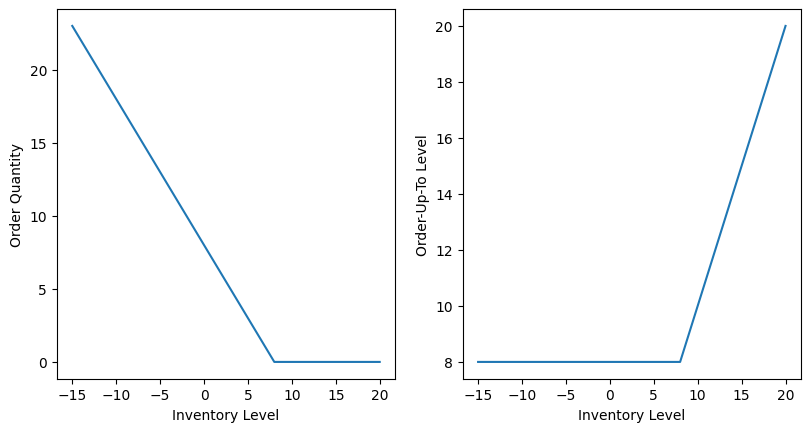

In [ ]:
# Plot the policy.
plot_policy(pi)

If all went well, the plot on the left (order quantity vs. inventory level) should decrease linearly with a slope of $-1$ until it flattens out at $y=0$; and the plot on the right (order-up-to level vs. inventory level) should be flat at first and then increase linearly with a slope of $1$. 

These shapes indicate that the optimal policy found by the MDP is a **base-stock policy:** We order up to a fixed value (the *base-stock level*), unless the inventory level is already greater than that value, in which case we order nothing. 

For this instance, the optimal base-stock level is 8. We can see this because the order-up-to level is 8 for any inventory levels less than or equal to 8; or because the order quantity is 0 when the inventory level is greater than or equal to 8.

In [ ]:
mdp_base_stock_level = list(pi[min_state].keys())[0] + min_state
print(f"Base-stock level found by MDP = {mdp_base_stock_level}")

Base-stock level found by MDP = 8


Next, let's evaluate this policy by running a handful of episodes. The `play()` function of the `MDP` class makes this easy.

In [ ]:
num_episodes = 100
T = 1000 # number of time steps per episode
avg_reward = 0
pbar = tqdm(total=num_episodes) # progress bar
for _ in range(num_episodes):
    pbar.update()
    total_reward, _ = mpnv_mdp.play(num_time_steps=T, policy=pi, messages=False)
    avg_reward += total_reward / num_episodes

print(f"After {num_episodes} episodes, average total discounted reward per episode = {avg_reward}")

  0%|          | 0/100 [00:00<?, ?it/s]

After 100 episodes, average total discounted reward per episode = -84.62076961346955


## Validation Using `stockpyl`

In this section, we'll validate the results of the MDP using `stockpyl`.


First we'll validate the base-stock level and average reward produced by the MDP. The MPNV problem with Poisson demand has a simple analytical solution, which is implemented in the `newsvendor.newsvendor_poisson()` function in `stockpyl`. (Documentation for this function is available [here](https://stockpyl.readthedocs.io/en/latest/api/seio/newsvendor.html#stockpyl.newsvendor.newsvendor_poisson).)

> **Note:** The `newsvendor_poisson()` function is actually solving the (single-period) newsvendor problem. However, the single-period and infinite-horizon versions of the problem have the same optimal solution and optimal expected cost per period (provided that either the discount factor or the purchase cost is 0; here, we are assuming the purchase cost is 0); see Snyder and Shen (2nd edition, 2019). Hence, we can use `newsvendor_poisson()` here.


In [ ]:
# Import the stockpyl modules we'll need.
from stockpyl.newsvendor import newsvendor_poisson
from stockpyl import sim
from stockpyl.supply_chain_network import single_stage_system

In [ ]:
# Solve the newsvendor problem with Poisson demand.
optimal_base_stock_level, optimal_cost = newsvendor_poisson(h, p, mu)
print(f"Optimal base-stock level is {optimal_base_stock_level}, with expected cost per period {optimal_cost}")

Optimal base-stock level is 8.0, with expected cost per period 4.34320221832773


The optimal base-stock level matches what the MDP found. The costs differ, though. That's because the MDP `play()` function reports the total discounted cost over the episode (which we set to 1000 periods), while the `newsvendor_poisson()` function reports the expected (undiscounted) cost per period. 

But if the expected cost per period is $g$, then the expected discounted cost over $T$ time periods is

$$\sum_{t=0}^{T-1} g\gamma^i = g\frac{1 - \gamma^{T}}{1-\gamma}$$

using standard formulas for geometric series. So:

In [ ]:
optimal_expected_discounted_cost_per_episode = optimal_cost * (1 - gamma**T) / (1 - gamma)
print(f"Expected discounted cost over {T} periods is {optimal_expected_discounted_cost_per_episode}")

Expected discounted cost over 1000 periods is 86.86404436655452


This cost is close to the (negative of the) reward reported by the MDP `play()` function.

Next, we'll simulate the system using `stockpyl`'s simulation features. This is analogous to using the `MDP.play()` approach. 

First we have to build the supply chain network to be simulated. The network must use a data structure provided by `stockpyl` called `SupplyChainNetwork`. There are several ways to build such an object in `stockpyl`. Since our network consists of only a single node, we'll use a built-in `stockpyl` function that builds a single-node network. We'll tell it to use the base-stock level returned by the `newsvendor_poisson()` function.

In [ ]:
# Build network to simulate.
network = single_stage_system(
    local_holding_cost=h,
    stockout_cost=p,
    demand_type='P',                    # Poisson demand
    mean=mu,
    policy_type='BS',                   # base-stock inventory policy
    base_stock_level=optimal_base_stock_level,
    shipment_lead_time=1                # this is necessary to convert between our sequence of events and stockpyl's
)

Now we run the simulation. The `simulation()` function returns the average (undiscounted) cost per period, which should match the expected cost per period that we found above. (This cell will take 30 seconds or so to execute.)

In [ ]:
# Simulate system.
mean_cost, _ = sim.run_multiple_trials(network, 10, 1000, progress_bar=False)
print(f"Average cost per period is {mean_cost}")

Average cost per period is 4.341600000000001


To summarize:

In [ ]:
print(tabulate([
    ["Base-stock level found by MDP", mdp_base_stock_level],
    ["Optimal base-stock level", optimal_base_stock_level],
    ["Average discounted reward per episode from MDP play()", avg_reward],
    ["Optimal expected discounted reward per episode", optimal_expected_discounted_cost_per_episode],
    ["Optimal expected cost per period", optimal_cost],
    ["Simulated average cost per period", mean_cost]
]))

-----------------------------------------------------  --------
Base-stock level found by MDP                            8
Optimal base-stock level                                 8
Average discounted reward per episode from MDP play()  -84.6208
Optimal expected discounted reward per episode          86.864
Optimal expected cost per period                         4.3432
Simulated average cost per period                        4.3416
-----------------------------------------------------  --------


### If You Have Extra Time

We have assumed that there is no **fixed cost** to place an order, in which case a base-stock policy is optimal.

Suppose now that we do have a fixed cost: We pay $K$ in each period in which we place a non-zero order, regardless of the size of the order. 

Write code to build an MDP with this cost structure. Solve the MDP using the same instance as before, plus $K=20$. Check whether the optimal actions follow an **$(s,S)$ policy**, in which the order quantity is given by

$$Q = \begin{cases} S-x, & x \le s \\ 0, & x > s \end{cases}$$

where $x$ is the inventory level and $S$ and $s$ are policy parameters called the **order-up-to** level and the **reorder point**, respectively. (Note: here, $s$ does not mean "state"! Sorry for the confusing notation!)

Also use `stockpyl` to find the optimal $s$ and $S$, via the `s_s_discrete_exact()` function (see documentation [here](https://stockpyl.readthedocs.io/en/latest/api/seio/ss.html#stockpyl.ss.s_s_discrete_exact)). In particular, the following code solves the $(s,S)$ problem for a Poisson distribution with mean `mu`:

```python
from stockpyl.ss import s_s_discrete_exact
s, S, cost = s_s_discrete_exact(holding_cost=h, stockout_cost=p, fixed_cost=K, use_poisson=True, demand_mean=mu)
```

(Unfortunately, `stockpyl` cannot (yet) handle fixed costs in the simulation, so you can't simulate this system.)

In [ ]:
## SOLUTIONS...

In [ ]:
def build_sS_dynamics(h: float, p: float, K: float, mu: int, min_state: int, max_state: int, 
                        max_order_quantity: int = None) -> dict:
    """Build a `dynamics` object for the (s,S) problem suitable for sending to an MDP object. 
    Assumes the demand has a Poisson distribution.

    `dynamics` is a dict whose keys are (state, action) pairs and whose values are dicts
    whose keys are (next_state, reward) pairs and whose values are probabilities.
    That is, dynamics[(s, a)][(s_prime, r)] is the probability that state s_prime and reward r
    results from taking action a in state s.
    Only (next_state, reward) pairs that have nonzero probability are included.

    Parameters
    ----------
    h : 
        Per-period holding cost.
    p : 
        Per-period stockout cost.
    K :
        Fixed cost.
    mu : 
        Mean demand per period.
    min_state, max_state :
        Min and max of the state space. The state space will be 
        truncated to these limits. Although the true state space goes to negative 
        infinity (because the demand is unbounded) and to positive infinity (because 
        we don't know in advance how large the order will be), we must truncate it.
    max_order_quantity : Maximum allowable order quantity. Used to reduce the 
        action space, if desired. Set to None (the default) to allow all order 
        quantities (up to the maximum of the state space).
    gamma : 
        Discount factor. Defaults to 0.95.
    """
    # Constants.
    max_order_quantity = max_order_quantity or max_state - min_state + 1

    # Build state space.
    state_space = list(range(min_state, max_state + 1))
    action_space = list(range(max_order_quantity + 1))

    # Build the `dynamics` dict:
    # 	for each s in the state space:
    #   	for each a in the action space such that s + a is in the state space: 
    #       	for each demand d such that s + a - d is in the state space:
    #           	set dynamics[s, a][s_prime, r] = P(D = d) for the appropriate
    #           	values of s_prime and r (where P(D = d) is the probability that
    #           	the demand equals d)
    dynamics = {}
    for s in state_space:
        for a in action_space:
            # Make sure OUL is within state space truncation.
            if s + a in state_space:
                dynamics[s, a] = {}
                # Only consider demands that would not take us past the minimum state.
                for d in range(s + a - min_state + 1):
                    oul = s + a
                    s_prime = oul - d
                    r = -(h * max(0, oul - d) + p * max(0, d - oul))
                    if a > 0:
                        r -= K
                    dynamics[s, a][s_prime, r] = poisson.pmf(d, mu)

    # The probabilities for each (s, a) pair will not sum to 1 because of the
    # state-space truncation. Artificially inflate the probability for the
    # minimum state to account for this.
    for s, a in list(dynamics.keys()):
        r = [rew for s_prime, rew in list(dynamics[s, a].keys()) if s_prime == min_state][0]
        dynamics[s, a][min_state, r] += 1 - np.sum(list(dynamics[s, a].values()))
        # Double-check that the probabilities sum to 1.
        assert np.isclose(np.sum(list(dynamics[s, a].values())), 1, atol=1.0e-6)
   
    return dynamics

In [ ]:
def build_s_S_MDP(h: float, p: float, K: float, mu: int, min_state: int, max_state: int, 
                   max_order_quantity: int = None, initial_state: int = 0, 
                   gamma: float = 0.95) -> MDP:
    """Build an MDP object representing an (s,S) problem. Assumes the demand has a Poisson distribution.

    In the MDP, a state represents an inventory position (= on-hand inventory minus backorders plus
    on-order inventory) and an action represents an order quantity. The objective is to maximize the
    negative of the total discounted cost over the infinite horizon.

    For parameter descriptions, see docstring for `build_MPNV_dynamics()`.
    """

    dynamics = build_sS_dynamics(h, p, K, mu, min_state, max_state, max_order_quantity)
    
    sS_MDP = MDP(
        dynamics=dynamics,
        initial_state=initial_state, 
        terminal_states=[],
        gamma=gamma
    )

    return sS_MDP

In [ ]:
# Set problem parameters.
h = 1
p = 10
K = 20
mu = 5
min_state = -15
max_state = 40
gamma = 0.95

In [ ]:
# Build the MDP.
ss_mdp = build_s_S_MDP(h=h, p=p, K=K, mu=mu, min_state=min_state, max_state=max_state, gamma=gamma)

In [ ]:
# Optimize the order quantities using value iteration.
pi = ss_mdp.value_iteration()

# Alternately, use policy iteration.
#_, pi = mpnv_mdp.policy_iteration()

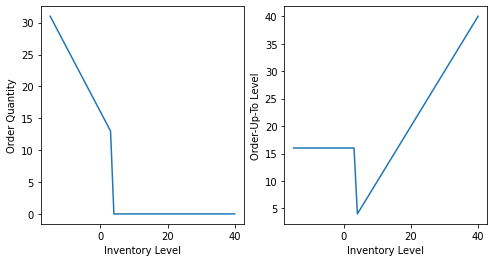

In [ ]:
plot_policy(pi)

In [ ]:
from stockpyl.ss import s_s_discrete_exact
s, S, cost = s_s_discrete_exact(holding_cost=h, stockout_cost=p, fixed_cost=K, use_poisson=True, demand_mean=mu)
print(f"s = {s}, S = {S}, cost = {cost}")

s = 3.0, S = 17.0, cost = 14.855729248943877
